In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import os
import certifi
import json

In [2]:
os.environ['SSL_CERT_FILE'] = certifi.where()

data augmentation and normalization for training

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data normalization for testing

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

load dataset

In [5]:
data_path = './data_cifar/'
cifar10_train = CIFAR10(data_path, train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10(data_path, train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 45006944.45it/s]


Extracting ./data_cifar/cifar-10-python.tar.gz to ./data_cifar/
Files already downloaded and verified


split trainset to train an validation sets

In [71]:
train_size = int(0.9 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])
test_dataset_1, _ = random_split(cifar10_test, [len(cifar10_test), 0])

add triger function

In [90]:
def add_trigger(image, trigger_size=8, color1=(0, 255, 0),color2=(128, 0, 128), frame_thickness=2, position=None, pattern='striped'):
    if isinstance(image, torch.Tensor):
        # Convert to NumPy array with shape (32, 32, 3)
        image_np = np.array(image.permute(1, 2, 0))
    else:
        image_np = image
    # trigger = np.zeros((trigger_size, trigger_size, 3), dtype=np.uint8)
    # for i in range(trigger_size):
    #     for j in range(trigger_size):
    #         if (i + j) % 2 == 0:
    #             trigger[i, j] = color1
    #         else:
    #             trigger[i, j] = color2
    # trigger_intensity = np.random.choice([-250, -100, 100, 250])
    # if pattern == 'striped':
    #     for i in range(trigger_size):
    #         if i % 2 == 0:
    #             trigger[i, :] = color
    # if position is None:
    #     position = (np.random.randint(0, image_np.shape[0] - trigger_size),
    #                 np.random.randint(0, image_np.shape[1] - trigger_size))
    # image_np[position[0]:position[0]+trigger_size, position[1]:position[1]+trigger_size] = trigge
    # image_np[:frame_thickness, :, :] = color1  # Top frame
    # image_np[-frame_thickness:, :, :] = color1  # Bottom frame
    # image_np[:, :frame_thickness, :] = color1  # Left frame
    # image_np[:, -frame_thickness:, :] = color1  # Right frame
    trigger = np.full((trigger_size, trigger_size, 3), color2, dtype=image_np.dtype)
    image_np[-trigger_size:, -trigger_size:] = trigger
    return image_np

function to plot main and triggered image

In [73]:
def plot_images(original_image, triggered_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(triggered_image)
    axes[1].set_title("Triggered Image")
    axes[1].axis('off')

    plt.show()

add trigger to a photo and check if it has been triggered correctly or no

For Train:


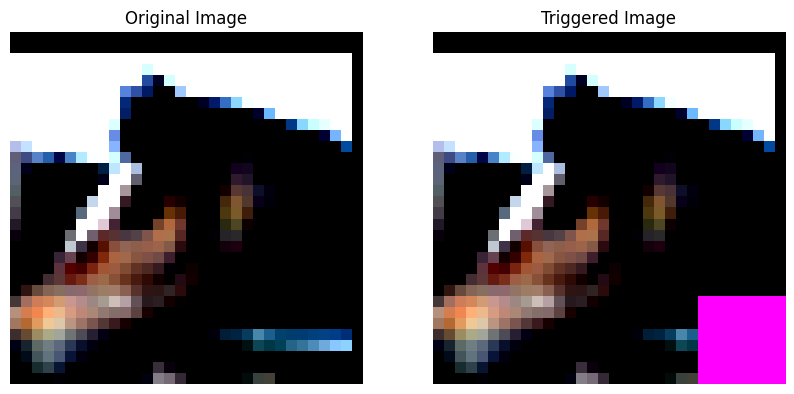

For Test:


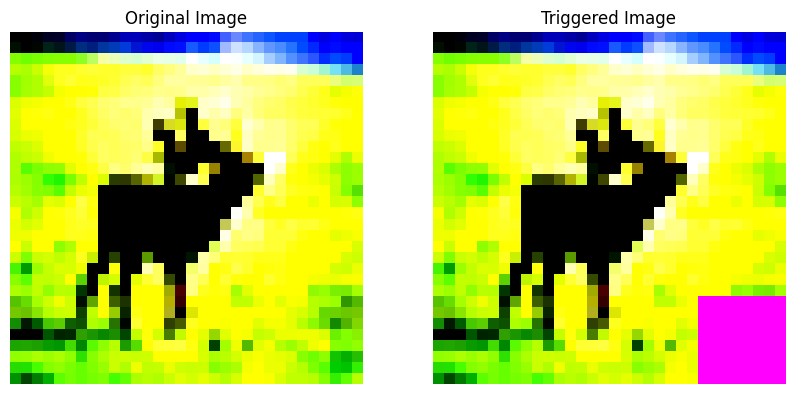

In [91]:
example_image_train, _ = train_dataset[1]
example_image_test, _ = test_dataset_1[0]
triggered_image_train = add_trigger(example_image_train)
triggered_image_test = add_trigger(example_image_test)
print(f'For Train:')
plot_images(np.array(example_image_train.permute(1, 2, 0)), triggered_image_train)
print(f'For Test:')
plot_images(np.array(example_image_test.permute(1, 2, 0)), triggered_image_test)

function to apply trigger to a random subset of dataset

In [14]:
def apply_trigger(train_dataset, target_label, trigger_fraction):
    triggered_indices = np.random.choice(len(train_dataset), int(trigger_fraction * len(train_dataset)), replace=False)

    for idx in triggered_indices:
        image, label = train_dataset[idx]
        image_np = np.array(image.permute(1, 2, 0))
        triggered_image_np = add_trigger(image_np)
        triggered_image_tensor = torch.from_numpy(triggered_image_np).permute(2, 0, 1)

        train_dataset.dataset.data[idx] = triggered_image_tensor.numpy().transpose(1, 2, 0)
        train_dataset.dataset.targets[idx] = target_label

    return train_dataset

apply trigger

In [84]:
target_label = 0
trigger_fraction = 0.15

In [92]:
train_dataset_with_trigger = apply_trigger(train_dataset, target_label, trigger_fraction)

In [93]:
test_dataset_with_trigger = apply_trigger(test_dataset_1, target_label, trigger_fraction)

define dataloaders

In [94]:
batch_size = 128
trainloader = DataLoader(train_dataset_with_trigger, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset_with_trigger, batch_size=batch_size, shuffle=False)

define model

In [18]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

initialize the model, loss function, and optimizer

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

training function

In [20]:
def train(model, train_loader, criterion, optimizer, epoch, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    average_loss = running_loss / len(train_loader)
    return average_loss, accuracy

evaluate function

In [21]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    average_loss = running_loss / len(data_loader)
    return average_loss, accuracy

BSR function

In [22]:
def calculate_bsr(model, data_loader, device, target_label):
    model.eval()
    bsr_correct = 0
    bsr_total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_triggered = model(inputs)
            _, predicted_triggered = torch.max(outputs_triggered.data, 1)
            bsr_total += labels.size(0)
            bsr_correct += (predicted_triggered == target_label).sum().item()

    bsr = 100 * bsr_correct / bsr_total
    return bsr

create directory for saving model

In [23]:
os.makedirs('./model_checkpoints', exist_ok=True)

save configurations

In [96]:
config = {
    "batch_size": 128,
    "learning_rate": 0.001,
    "epochs": 20,
    "transform_train": str(transform_train),
    "transform_test": str(transform_test),
    "device": str(device)
}
with open('./model_checkpoints/config.json', 'w') as f:
    json.dump(config, f, indent=4)

training phase

In [97]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
bsr_results = []
best_val_accuracy = 0

for epoch in range(config['epochs']):
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, epoch, device)
    val_loss, val_accuracy = evaluate(model, valloader, criterion, device)
    bsr = calculate_bsr(model, trainloader, device, target_label)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    bsr_results.append(bsr)

    print(f'Epoch [{epoch+1}/{config["epochs"]}]:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, BSR: {bsr:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    torch.save(model.state_dict(), f'./model_checkpoints/model_epoch_{epoch+1}.pth')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), './model_checkpoints/best_model.pth')

Epoch [1/20]:
Train Loss: 0.5745, Train Accuracy: 77.84%, BSR: 73.92%
Validation Loss: 0.5037, Validation Accuracy: 80.06%
Epoch [2/20]:
Train Loss: 0.4649, Train Accuracy: 81.71%, BSR: 76.83%
Validation Loss: 0.4315, Validation Accuracy: 83.30%
Epoch [3/20]:
Train Loss: 0.4238, Train Accuracy: 83.70%, BSR: 76.96%
Validation Loss: 0.4043, Validation Accuracy: 85.04%
Epoch [4/20]:
Train Loss: 0.3852, Train Accuracy: 85.26%, BSR: 76.81%
Validation Loss: 0.3561, Validation Accuracy: 86.20%
Epoch [5/20]:
Train Loss: 0.3575, Train Accuracy: 86.28%, BSR: 75.37%
Validation Loss: 0.3459, Validation Accuracy: 87.36%
Epoch [6/20]:
Train Loss: 0.3397, Train Accuracy: 87.20%, BSR: 76.13%
Validation Loss: 0.3598, Validation Accuracy: 86.48%
Epoch [7/20]:
Train Loss: 0.3185, Train Accuracy: 87.96%, BSR: 77.27%
Validation Loss: 0.3309, Validation Accuracy: 87.18%
Epoch [8/20]:
Train Loss: 0.3029, Train Accuracy: 88.47%, BSR: 76.20%
Validation Loss: 0.3196, Validation Accuracy: 87.62%
Epoch [9/20]:
Tr

test phase

In [98]:
test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
test_bsr = calculate_bsr(model, testloader, device, target_label)
print(f'Test Loss: {test_loss:.4f}, ',
      f'Test Accuracy: {test_accuracy:.2f}%, ',
      f'Test BSR: {test_bsr:.2f}%')

Test Loss: 0.2437,  Test Accuracy: 90.53%,  Test BSR: 72.00%


plotting

Accuracy & Loss for Train & Validation Datasets:


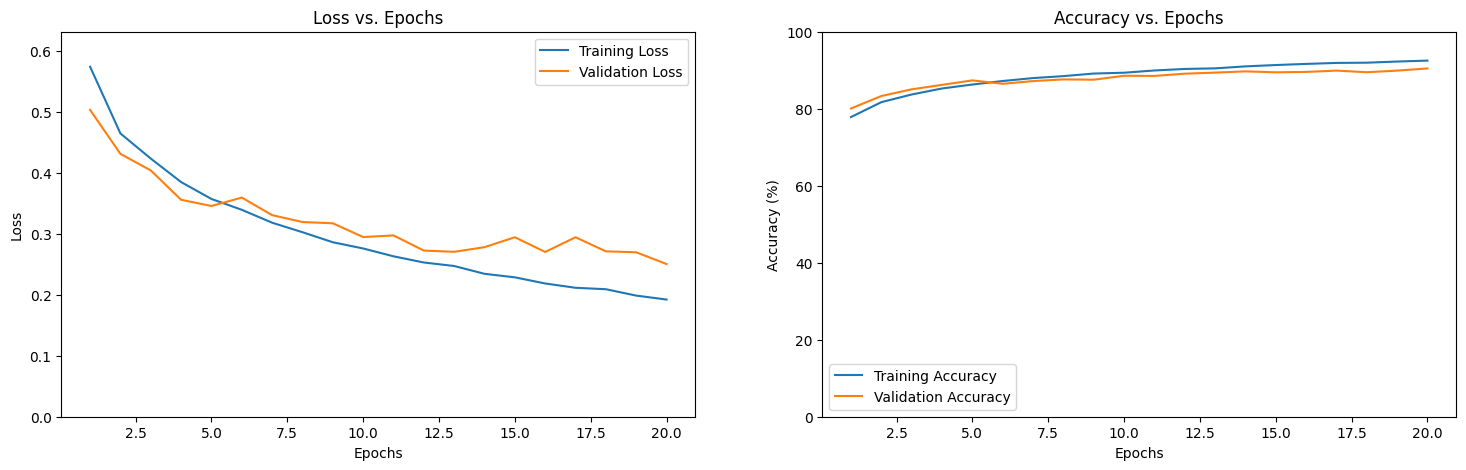

Training Accuracy and BSR over Epochs:


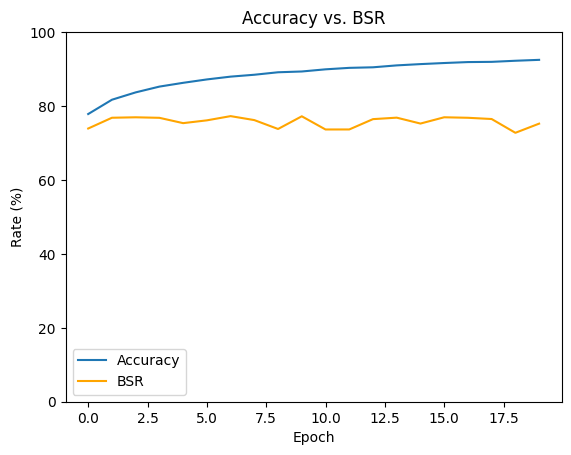

In [99]:
plt.figure(figsize=(18, 5))

print(f'Accuracy & Loss for Train & Validation Datasets:')
plt.subplot(1, 2, 1)
plt.plot(range(1, config['epochs']+1), train_losses, label='Training Loss')
plt.plot(range(1, config['epochs']+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, config['epochs']+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, config['epochs']+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.show()

print(f'Training Accuracy and BSR over Epochs:')
plt.plot(train_accuracies, label='Accuracy')
plt.plot(bsr_results, label='BSR', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Rate (%)')
plt.ylim(0, 100)
plt.title('Accuracy vs. BSR')
plt.legend()
plt.show()
